In [1]:
import sys
sys.path.append('/eos/user/s/sterbini/MD_ANALYSIS/public/')
sys.path.append('/eos/project/l/liu/Toolbox/')
from myToolbox import *
from scipy.signal import savgol_filter
import gzip
#from uncertainties import ufloat

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-862.14.4.el7.x86_64-x86_64-with-redhat-6.10-Carbon
Your folder is /eos/user/h/harafiqu/SWAN_projects/PS
Your IP is 172.17.0.13
2018-11-05 14:49:38


In [2]:
#myFiles=glob.glob('/eos/project/l/liu/PS/data/2018/MD4224_integer_emittance_scans/2018.09.05_vertical/2018*.mat')
myFiles=glob.glob('/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/2018*.mat')
#print myFiles

In [3]:
myFiles

['/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/2018.10.22.15.04.54.236.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/2018.10.22.15.05.31.451.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/2018.10.22.15.06.08.622.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/2018.10.22.15.06.45.820.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/2018.10.22.15.07.23.025.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/2018.10.22.15.08.00.232.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/2018.10.22.15.08.37.422.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/2018.10.22.15.09.14.611.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/2018.10.22.15.09.51.822.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/2018.10.22.15.10.29.025.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/2018.10.22.15.11.06.227.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/2018.10.22.15.11.43.524.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/2018.10.22.15.12.20.613.mat',
 '/eos/user/h/harafiqu/MD

In [4]:
def fromMatlabToDataFrame(listing, listOfVariableToAdd, verbose=False, matlabFullInfo=False):
    listOfVariableToAdd=list(set(listOfVariableToAdd))
    myDataFrame=pnd.DataFrame({})
    cycleStamp=[]
    cycleStampHuman=[]
    PLS_matlab=[]
    matlabObject=[]
    matlabFilePath=[]
    for j in listOfVariableToAdd:
        exec(j.replace('.','_')+'=[]')
    for i in listing:
        if verbose:
            print(i)
        data=myToolbox.japcMatlabImport(i);
        if matlabFullInfo:
            matlabObject.append(data)
        #to correct
        localCycleStamp=np.nanmax(data.headerCycleStamps);
        deltaLocal_UTC=datetime.datetime.fromtimestamp(localCycleStamp/1e9)-datetime.datetime.utcfromtimestamp(localCycleStamp/1e9)
        utcCycleStamp=localCycleStamp+deltaLocal_UTC.total_seconds()*1e9
        cycleStamp.append(utcCycleStamp)
        aux=myToolbox.unixtime2datetimeVectorize(np.nanmax(data.headerCycleStamps)/1e9)
        cycleStampHuman.append(aux.tolist())
        PLS_matlab.append(data.cycleName)
        matlabFilePath.append(os.path.abspath(i))
        for j in listOfVariableToAdd:
            if hasattr(data,j.split('.')[0]):
                exec(j.replace('.','_') + '.append(data.' + j + ')')
            else:
                exec(j.replace('.','_') + '.append(np.nan)')
    myDataFrame['cycleStamp']=pnd.Series(cycleStamp,cycleStampHuman)
    myDataFrame['matlabPLS']=pnd.Series(PLS_matlab,cycleStampHuman)
    myDataFrame['matlabFilePath']=pnd.Series(matlabFilePath,cycleStampHuman)
    if matlabFullInfo:
        myDataFrame['matlabFullInfo']=pnd.Series(matlabObject,cycleStampHuman)
    for j in listOfVariableToAdd:
        exec('myDataFrame[\'' + j + '\']=pnd.Series(' +j.replace('.','_')+ ',cycleStampHuman)')    #myDataFrame=pnd.DataFrame({j:aux,
    return myDataFrame

def intensity_df(ndf,start=85,end=1185):
    df=ndf.copy()
    def losses(a):
        try:
            b=(a[start]-a[end])/a[start]*100 
        except:
            b=np.nan
        return b
    def ratio(a):
        try:
            c=a[end]/a[start]
        except:
            c=np.nan
        return c
    def max_intensity(a):
        try:
            d=np.max(a)
        except:
            d=np.nan
        return d*1E10
    df['intensity']=df['PR_BCT_ST.Samples.value.samples'].apply(max_intensity)
    df['losses']=df['PR_BCT_ST.Samples.value.samples'].apply(losses)
    df['ratio']=df['PR_BCT_ST.Samples.value.samples'].apply(ratio)
    return df

def read_data(year=2018,month=9,date=5,hour=10,minutes=0,span=5,user='CPS%MD1',WS='64.V'):
    t1=datetime.datetime(year,month,date,hour,minutes)
    t2=t1+datetime.timedelta(hours=span)
    CALS=['PR.BWS.{}_ROT:PROF_DATA_IN'.format(WS),  'PR.BWS.{}_ROT:PROF_POSITION_IN'.format(WS),  'PR.BWS.{}_ROT:ACQ_DELAY'.format(WS), 'PR.BCT.LT:SAMPLES']
    df=myToolbox.fromTimberToDataFrame(CALS,t1,t2,fundamental=user)
    return  df

def span_range(df,myFiles=None):
    if myFiles:
        span=[i for i in xrange(len(df)) if datetime.datetime.strptime(myFiles[0][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')<df.index[i]<datetime.datetime.strptime(myFiles[-1][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')]
    else:
        span=xrange(len(df))
    return span

def gaussian_5_parameters(x, c, m, A, mu, sig):
    """gaussian_5_parameter(x, c, m, A, mu, sig)"""
    return c+m*x+A/np.sqrt(2*np.pi)/sig*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def makeGaussianFit_5_parameters(X,Y,for_df=False,window=50):
    try:      
        #i = np.where( (X>min(X)+10) & (X<max(X)-10) )
        i = np.where( (X>-40) & (X<40) )
        #i = np.where( (Y>1.01*min(Y)) & (Y<0.99*max(Y)) )
        X = X[i]
        Y = Y[i]
        indx_max = np.argmax(Y)
        mu0 = X[indx_max]
        window = window
        x_tmp = X[indx_max-window:indx_max+window]
        y_tmp = Y[indx_max-window:indx_max+window]
        offs0 = min(y_tmp)
        ampl = max(y_tmp)-offs0
        x1 = x_tmp[np.searchsorted(y_tmp[:window], offs0+ampl/2)]
        x2 = x_tmp[np.searchsorted(-y_tmp[window:], -offs0+ampl/2)]
        FWHM = x2-x1
        sigma0 = np.abs(2*FWHM/2.355)
        ampl *= np.sqrt(2*np.pi)*sigma0
        slope = 0
        popt,pcov = curve_fit(gaussian_5_parameters,X,Y,p0=[offs0,slope,ampl,mu0,sigma0])
        if for_df:
            return popt[2], popt[0], popt[3], popt[4]
        else:    
            return popt#{'c': popt[0], 'm': popt[1],'A': popt[2], 'mu': popt[3], 'sig': popt[4], 'pcov': pcov, 'p': popt}
    except:
        if for_df:
            return np.nan,np.nan, np.nan, np.nan
        else:
            return [np.nan,np.nan, np.nan, np.nan,np.nan]#{k: np.nan for k in ['c', 'm','A', 'mu', 'sig', 'pcov', 'p']}def span_range(df,myFiles=None):
    if myFiles:
        span=[i for i in xrange(len(df)) if datetime.datetime.strptime(myFiles[0][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')<df.index[i]<datetime.datetime.strptime(myFiles[-1][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')]
    else:
        span=xrange(len(df))
    return span

def filtered(a):
    try:
        b=(scipy.signal.savgol_filter(a,15,1))
    except:
        b=np.nan
    return b

def profiles(ndf,WS='64.V',myFiles=None):
    df=ndf.copy()
    # play with these limits
    #x=np.linspace(-40,40,1000)
    x=np.linspace(-25,25,1000)
    a=df.columns
    if 'profile '+WS[-1] not in a:
        df['profile '+WS[-1]]=df['PR.BWS.{}_ROT:PROF_DATA_IN'.format(WS)].apply(filtered)
        df['position '+WS[-1]]=df['PR.BWS.{}_ROT:PROF_POSITION_IN'.format(WS)].values/1000.
    if 'sig '+WS[-1] not in a:
        df['sig '+WS[-1]]=np.nan
        df['mu '+WS[-1]]=np.nan
        df['c '+WS[-1]]=np.nan
        df['A '+WS[-1]]=np.nan

    span=span_range(df,myFiles=myFiles)
    if np.isnan(df['sig '+WS[-1]].iloc[span]).all():
        for i in span:
            df['A '+WS[-1]].iloc[i],df['c '+WS[-1]].iloc[i],df['mu '+WS[-1]].iloc[i],df['sig '+WS[-1]].iloc[i]=makeGaussianFit_5_parameters(df['position '+WS[-1]].iloc[i],df['profile '+WS[-1]].iloc[i],for_df=True)
            try:
                yz=scipy.interpolate.interp1d(df['position '+WS[-1]].iloc[i]-df['mu '+WS[-1]].iloc[i],df['profile '+WS[-1]].iloc[i]-df['c '+WS[-1]].iloc[i])(x)
                if np.isnan(yz[0]):
                    yz=np.nan
            except:
                yz = np.nan
            df['profile '+WS[-1]].iloc[i]=yz
            df['position '+WS[-1]].iloc[i]=x
    return df

def second_moment_2(values, weights, sig, n_sigmas=6.):
    a=np.where((values<n_sigmas*sig) & (values>-n_sigmas*sig))[0]
    values=values[a]
    weights=weights[a]    
    weighted_average = np.average(values, weights=weights)
    second_moment = np.sqrt(np.average((values-weighted_average)**2, weights=weights))
    return (second_moment)

def PS_WSoptics_old(tunex, tuney, WS='65'):
    qv, qh, wire, betx, bety, dx, dy= np.loadtxt('/eos/user/h/harafiqu/SWAN_projects/PS/optic_values_new.dat', dtype=([('qv',float),('qh',float),('wire',float),('betx',float),('bety',float),('dx',float),('dy',float)]),comments='#',unpack=True)
    startindx = {'64': 0, '65': 961, '68': 1922, '85':2883}
    stopindx = {'64': 960, '65': 1921, '68': 2882, '85':3843}
    bx = betx[startindx[WS]:stopindx[WS]]
    by = bety[startindx[WS]:stopindx[WS]]
    Dx = dx[startindx[WS]:stopindx[WS]]
    qh1=qh[startindx[WS]:stopindx[WS]]
    qv1=qv[startindx[WS]:stopindx[WS]]
    betax = scipy.interpolate.interp2d(qh1,qv1,bx)
    betay = scipy.interpolate.interp2d(qh1,qv1,by)
    dispx = scipy.interpolate.interp2d(qh1,qv1,Dx)
    result ={'Beta_x':betax(tunex,tuney), 'Beta_y':betay(tunex,tuney),'D_x': dispx(tunex,tuney)}
    #print 'PS_Woptics: Qx, Qy, Beta_x, Beta_y, D_x'
    #print tunex, '\t', tuney, '\t', betax(tunex,tuney), '\t', betay(tunex, tuney), '\t', dispx(tunex, tuney)
    return result


def PS_WSoptics(tunex, tuney, WS='65'):
    qv, qh, wire, betx, bety, dx, dy= np.loadtxt('/eos/user/h/harafiqu/SWAN_projects/PS/optic_values_6p01_6p35.dat', dtype=([('qv',float),('qh',float),('wire',float),('betx',float),('bety',float),('dx',float),('dy',float)]),comments='#',unpack=True)
    file_iter = 4586
    startindx = {'64': 0, '65': (file_iter+1), '68': (2*file_iter)+1, '85':(3*file_iter)+1}
    stopindx = {'64': file_iter, '65': (2*file_iter), '68': (3*file_iter), '85':(4*file_iter)}
   
    def five_round(x, base=5):
        return int(base * round(float(x)/base))
    
    # Translate tunex, tuney, WS into a line number using the sequence of saved tunes
    # Need to handle the 0.005 step now (previously rounded to nearest 'integer')
    # File iterates from Qx,y = 4.01 - 4.35 in steps of 0.005 = 68 steps
    f_steps = 68
    f_xstart = 0.01
    f_ystart = 0.01
    line_number = (int(five_round((tunex-f_xstart)*100)*f_steps)) + (int(five_round((tuney-f_ystart)*100))) + startindx[WS]
    
    
    # Translate tunex, tuney, WS into a line number using the sequence of saved tunes
   # line_number = (int(round((tunex-.05)*100)*31)) + (int(round((tuney-.05)*100))) + startindx[WS]
    
    result ={'Beta_x':betx[line_number], 'Beta_y':bety[line_number],'D_x': dx[line_number]}
    #print 'PS_Woptics: Line_no, Tunex, Tuney, Qx, Qy, Beta_x, Beta_y, D_x'
    #print line_number, '\t',tunex, '\t', tuney, '\t', qh[line_number], '\t', qv[line_number], '\t', betx[line_number], '\t', bety[line_number], '\t', dx[line_number]
    return result

def twiss(ndf,WS='65.H',myFiles=None):
    df=ndf.copy()
    a=df.columns
    if 'betx' not in a:
        df['betx']=np.nan
    if 'bety' not in a:
         df['bety']=np.nan
    if 'dx' not in a:
         df['dx']=np.nan
    span=span_range(df,myFiles=myFiles)
    for i in span:
            df.loc[df.index[i],'betx']=PS_WSoptics(df['Qx'].iloc[i],df['Qy'].iloc[i],WS=WS[:-2])['Beta_x']
            df.loc[df.index[i],'dx']=PS_WSoptics(df['Qx'].iloc[i],df['Qy'].iloc[i],WS=WS[:-2])['D_x']
            df.loc[df.index[i],'bety']=PS_WSoptics(df['Qx'].iloc[i],df['Qy'].iloc[i],WS=WS[:-2])['Beta_y']
    return df

def emittance_df(ndf,WS='65.H',myFiles=None,beta=0.91444281513833,gamma=2.4708737618826,dp=1e-3):
    df=ndf.copy()
    a=df.columns
    if 'emittance V' not in a:
        df['emittance V']=np.nan
    if 'emittance H' not in a:
        df['emittance H']=np.nan
    if 'sig V' not in a:
        df=profiles(df,WS=WS)
    if 'sig H' not in a:
        df=profiles(df,WS=WS)
    span=span_range(df,myFiles=myFiles)
    if WS[-1]=='V':
        if 'bety' not in a:
            df=twiss(df,WS=WS)
        for i in span:
            df.loc[df.index[i],'emittance V']=beta*gamma*(df['sig V'].iloc[i]**2)/df['bety'].iloc[i]
    else:
        if 'betx' not in a:
            df=twiss(df,WS=WS)
        for i in span:
            df.loc[df.index[i],'emittance H']=beta*gamma*(df['sig H'].iloc[i]**2-(df['dx'].iloc[i]*1000)**2*dp**2)/df['betx'].iloc[i]
    return df

In [ ]:
#myDataStruct = scipy.io.loadmat('/eos/project/l/liu/PS/data/2018/MD4224_integer_emittance_scans/2018.09.05_vertical/2018.09.05.13.47.50.436.mat',squeeze_me=True, struct_as_record=False)

#myDataStruct = scipy.io.loadmat('/eos/project/l/liu/PS/data/2018/MD4224_integer_emittance_scans/2018.09.05_vertical/2018.09.05.13.47.50.436.mat',squeeze_me=True)

# Make a master dataframe?

In [5]:
df_test = fromMatlabToDataFrame(myFiles,['PR_BQS72.SamplerAcquisition.value.estimatedTuneV','PR_BQS72.SamplerAcquisition.value.estimatedTuneH','PR_BQS72.SamplerAcquisition.cycleStamp','PR_BCT_ST.Samples.value.samples','PR_BCT_ST.Samples.cycleStamp'])

In [6]:
df_test['PR_BCT_ST.Samples.cycleStamp']=df_test['PR_BCT_ST.Samples.cycleStamp']/1e9
df_test['PR_BQS72.SamplerAcquisition.cycleStamp']=df_test['PR_BQS72.SamplerAcquisition.cycleStamp']/1e9

In [7]:
# Check cyclestamp differences

# Iterate over each row in the dataframe
differences = []
for index, row in df_test.iterrows():
    difference = (row['PR_BCT_ST.Samples.cycleStamp'] - row['PR_BQS72.SamplerAcquisition.cycleStamp'])/row['PR_BCT_ST.Samples.cycleStamp']
    differences.append(difference)
    
print 'Difference between BCT and BQS73 cycle times (percentage) \n Mean:', np.mean(differences),' Min:',np.min(differences),' Max:', np.max(differences)

# Iterate over each row in the dataframe
differences = []
for index, row in df_test.iterrows():
    difference = (row['cycleStamp'] - (row['PR_BCT_ST.Samples.cycleStamp']*1E9))/row['cycleStamp']
    differences.append(difference)
    
print '\nDifference between BCT and cyclestamp cycle times (percentage) \n Mean:', np.mean(differences),' Min:',np.min(differences),' Max:', np.max(differences)

Difference between BCT and BQS73 cycle times (percentage) 
 Mean: 3.5616399734512503e-11  Min: 0.0  Max: 1.2465739907079376e-08

Difference between BCT and cyclestamp cycle times (percentage) 
 Mean: 4.6848598103536595e-06  Min: 4.6746018656182955e-06  Max: 4.734604699667532e-06


In [12]:
df_test

,cycleStamp,matlabPLS,matlabFilePath,PR_BQS72.SamplerAcquisition.value.estimatedTuneV,PR_BQS72.SamplerAcquisition.cycleStamp,PR_BCT_ST.Samples.cycleStamp,PR_BCT_ST.Samples.value.samples,PR_BQS72.SamplerAcquisition.value.estimatedTuneH
2018-10-22 15:03:36.700,1.540221e+18,CPS.USER.MD5,/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/201...,"[0.05288312232099775, 0.04456812453730941, 0.0...",1.540213e+09,1.540213e+09,"[-0.18033000000000002, -0.18095000000000003, -...","[0.30704418828706137, 0.30869351006081114, 0.2..."
2018-10-22 15:04:13.900,1.540221e+18,CPS.USER.MD5,/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/201...,"[0.050023554259455066, 0.0372281557742819, 0.0...",1.540213e+09,1.540213e+09,"[-0.16071000000000002, -0.14967000000000003, -...","[0.3068991660883332, 0.269892604456834, 0.3102..."
2018-10-22 15:04:51.100,1.540221e+18,CPS.USER.MD5,/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/201...,"[0.04069338677652971, 0.043495622537602835, 0....",1.540213e+09,1.540213e+09,"[-0.23615000000000003, -0.23063000000000003, -...","[0.3103148034739845, 0.26892102657082156, 0.31..."
2018-10-22 15:05:28.300,1.540221e+18,CPS.USER.MD5,/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/201...,"[0.0500558218900933, 0.047342701554220386, 0.0...",1.540214e+09,1.540214e+09,"[-0.2018, -0.17911000000000002, -0.16561, -0.1...","[0.30674728664972545, 0.3102089218512272, 0.28..."
2018-10-22 15:06:05.500,1.540221e+18,CPS.USER.MD5,/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/201...,"[0.04050707404796127, 0.04635390250760769, 0.0...",1.540214e+09,1.540214e+09,"[-0.18401, -0.17175, -0.16255, -0.14476, -0.11...","[0.3071536844573533, 0.3102277936945241, 0.283..."
2018-10-22 15:06:42.700,1.540221e+18,CPS.USER.MD5,/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/201...,"[0.033806064567782484, 0.034981518007825944, 0...",1.540214e+09,1.540214e+09,"[-0.1423, -0.1423, -0.13740000000000002, -0.12...","[0.3065450476459729, 0.3065627970094629, 0.306..."
2018-10-22 15:07:19.900,1.540221e+18,CPS.USER.MD5,/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/201...,"[0.03498853148723004, 0.0375738208259048, 0.03...",1.540214e+09,1.540214e+09,"[-0.23002000000000003, -0.21959, -0.2128400000...","[0.3061451744965557, 0.3057141688744733, 0.306..."
2018-10-22 15:07:57.100,1.540221e+18,CPS.USER.MD5,/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/201...,"[0.036815950523157996, 0.03651140654818192, 0....",1.540214e+09,1.540214e+09,"[-0.21775000000000003, -0.20303000000000002, -...","[0.3064899014315229, 0.3066957314239704, 0.306..."
2018-10-22 15:08:34.300,1.540221e+18,CPS.USER.MD5,/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/201...,"[0.03564760463165521, 0.03572595292716845, 0.0...",1.540214e+09,1.540214e+09,"[-0.14476, -0.12145000000000002, -0.1140900000...","[0.30637545760834023, 0.30632399352201556, 0.3..."
2018-10-22 15:09:11.500,1.540221e+18,CPS.USER.MD5,/eos/user/h/harafiqu/MD4224/2018.10.22_qpu/201...,"[0.03558314381315566, 0.035961819554210496, 0....",1.540214e+09,1.540214e+09,"[-0.16745000000000002, -0.15396, -0.15396, -0....","[0.30615405907500237, 0.3058287258018807, 0.30..."


In [ ]:
df_bct = fromMatlabToDataFrame(myFiles,['PR_BCT_ST.Samples.value.samples','PR_BCT_ST.Samples.cycleStamp'])
df_bqs72 = fromMatlabToDataFrame(myFiles,['PR_BQS72.SamplerAcquisition.value.estimatedTuneV','PR_BQS72.SamplerAcquisition.value.estimatedTuneH','PR_BQS72.SamplerAcquisition.cycleStamp'])

In [ ]:
df_mergetest = pnd.merge(df_bct, df_bqs72, left_on = 'PR_BCT_ST.Samples.cycleStamp',  right_on = 'PR_BQS72.SamplerAcquisition.cycleStamp')
#df_mergetest

In [ ]:
df_mergetest['PR_BQS72.SamplerAcquisition.cycleStamp']=df_mergetest['PR_BQS72.SamplerAcquisition.cycleStamp']/1e9
df_mergetest['cf_cycleStamp']=df_mergetest['PR_BQS72.SamplerAcquisition.cycleStamp']
df_mergetest = df_mergetest.rename(index=str, columns={"PR_BQS72.SamplerAcquisition.cycleStamp" : "cycleStamp", })
df_mergetest['PR_BQS72.SamplerAcquisition.cycleStamp']=df_mergetest['cycleStamp'].apply(myToolbox.unixtime2datetimeVectorize)
df_mergetest['timeStamp'] = df_mergetest['cycleStamp'].apply(myToolbox.unixtime2datetimeVectorize)
df_mergetest = df_mergetest.set_index(['cycleStamp'])
df_mergetest = df_mergetest.drop(labels='matlabFilePath_x',axis='columns')
df_mergetest = df_mergetest.drop(labels='matlabFilePath_y',axis='columns')
df_mergetest = df_mergetest.drop(labels='cycleStamp_x',axis='columns')
df_mergetest = df_mergetest.drop(labels='cycleStamp_y',axis='columns')
df_mergetest = df_mergetest.drop(labels='matlabPLS_y',axis='columns')
df_mergetest = df_mergetest.drop(labels='matlabPLS_x',axis='columns')
df_mergetest = df_mergetest.drop(labels='PR_BCT_ST.Samples.cycleStamp',axis='columns')

In [ ]:
df_mergetest

# Tune using master df 

In [ ]:
# properly handle the tune time

test = myToolbox.japcMatlabImport(myFiles[0])

# Start of timing
tune_start_time = (test.PR_BQS72.SamplerAcquisition.value.acqOffset + 170)
tune_period = test.PR_BQS72.SamplerAcquisition.value.acqPeriod
number_of_acq = test.PR_BQS72.SamplerAcquisition.value.nbOfMeas
interval = test.PR_BQS72.SamplerAcquisition.value.acqPeriod

#end of timing = number of ac * interval
tune_end_time = (number_of_acq * interval)
tune_time_steps = ((tune_end_time - tune_start_time) / number_of_acq)

sequence = np.linspace(tune_start_time, tune_end_time, number_of_acq)
#tune_end_time - tune_start_time
#tune_start_time
#tune_end_time
#np.size(sequence)

if np.size(sequence) != number_of_acq:
    print 'ERROR'
else:
    print 'Correct sequence created for tune x axis'

In [ ]:
df_mergetest['Qx']=df_mergetest.apply(lambda x: np.nanmean(x['PR_BQS72.SamplerAcquisition.value.estimatedTuneH'][20:280]),axis=1)
df_mergetest['Qy']=df_mergetest.apply(lambda x: np.nanmean(x['PR_BQS72.SamplerAcquisition.value.estimatedTuneV'][20:280]),axis=1)

In [ ]:
# Plot all Horizontal tune measurements
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
df_mergetest.apply(lambda x: plt.plot(sequence, x['PR_BQS72.SamplerAcquisition.value.estimatedTuneH']),axis=1)
plt.xlabel('Acquisition Time [ms]')
plt.ylabel('Qx [-]')
plt.title('Vertical Scan: Horizontal Tunes')
plt.grid()
plt.xlim(190, 200)
plt.ylim(0.3, 0.31)
fig.savefig('MD4224_LowBrightness_Vertical_QX.png')

In [ ]:
# Plot all Vertical tune measurements
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
df_mergetest.apply(lambda x: plt.plot(sequence, x['PR_BQS72.SamplerAcquisition.value.estimatedTuneV']),axis=1)
plt.xlabel('Acquisition Time [ms]')
plt.xlim(190, 200)
plt.ylim(0.005, 0.12)
plt.ylabel('Qy [-]')
plt.title('Vertical Scan: Vertical Tunes')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_QY.png')

In [ ]:
df_mergetest = df_mergetest.drop(labels='PR_BQS72.SamplerAcquisition.value.estimatedTuneV',axis='columns')
df_mergetest = df_mergetest.drop(labels='PR_BQS72.SamplerAcquisition.value.estimatedTuneH',axis='columns')
#df_mergetest

# Intensity and Losses 

In [ ]:
df_mergetest = df_mergetest.dropna(axis=0,how='all',subset =['Qy'])
df_mergetest = df_mergetest.dropna(axis=0,how='all',subset =['Qx'])
df_mergetest=intensity_df(df_mergetest,start=70,end=1185)

In [ ]:
df_mergetest = df_mergetest.drop(labels='PR_BCT_ST.Samples.value.samples',axis='columns')
#df_mergetest

In [ ]:
# Plot intensity as a function of Vertical tune
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_mergetest['Qy'], df_mergetest['intensity'],'o')
plt.xlabel('Qy [-]')
plt.ylabel('Intensity [protons]')
plt.title('Vertical Scan: Intensity')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_Intensity_Qy.png')

In [ ]:
# Plot intensity as a function of Horizontal tune
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_mergetest['Qx'], df_mergetest['intensity'],'o')
plt.xlabel('Qx [-]')
plt.ylabel('Intensity [protons]')
plt.title('Vertical Scan: Intensity')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_Intensity_Qx.png')

In [ ]:
# Plot losses as a function of Vertical tune
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_mergetest['Qy'], df_mergetest['losses'],'o')
plt.xlabel('Qy [-]')
plt.ylabel('Losses [%]')
plt.title('Vertical Scan: Losses')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_Losses_Qy.png')

In [ ]:
# Plot losses as a function of Vertical tune
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_mergetest['Qx'],df_mergetest['losses'],'o')
plt.xlabel('Qx [-]')
plt.ylabel('Losses [%]')
plt.title('Vertical Scan: Losses')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_Losses_Qx.png')

# Vertical Timber

In [8]:
dfV=read_data(year=2018,date=22,month=10,hour=15,minutes=4,span=5,user='CPS%MD5',WS='85.V')
dfV=profiles(dfV,WS='85.V')
dfV

/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)
/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in double_scalars
/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:81: RuntimeWarning: divide by zero encountered in divide
/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in divide
/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:81: RuntimeWar

,PR.BWS.85.V_ROT:PROF_POSITION_IN,PR.BWS.85.V_ROT:PROF_DATA_IN,PR.BWS.85.V_ROT:ACQ_DELAY,PR.BCT.LT:SAMPLES,cycleStamp,profile V,position V,sig V,mu V,c V,A V
2018-10-22 15:04:13.900,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.147938429462117, 0.147594585714287, 0.14811...",172.0,"[-0.16071, -0.14967, -0.14844, -0.13678, -0.12...",1.540221e+18,NaN,"[-25.0, -24.94994994994995, -24.8998998998999,...",0.000000,-32.286000,0.147973,0.000000
2018-10-22 15:04:51.100,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.148801547445958, 0.148628521930821, 0.14880...",172.0,"[-0.23615, -0.23063, -0.21714, -0.19812, -0.17...",1.540221e+18,NaN,"[-25.0, -24.94994994994995, -24.8998998998999,...",0.760951,-31.549972,0.170810,10.159941
2018-10-22 15:05:28.300,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.148801547445958, 0.148110651607865, 0.14776...",175.0,"[-0.2018, -0.17911, -0.16561, -0.14783, -0.129...",1.540221e+18,"[0.001226735996575861, 0.0013014092466854515, ...","[-25.0, -24.94994994994995, -24.8998998998999,...",3.150984,-3.799505,0.153027,0.845574
2018-10-22 15:06:05.500,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.147594585714287, 0.146909293882681, 0.14742...",185.0,"[-0.18401, -0.17175, -0.16255, -0.14476, -0.11...",1.540221e+18,"[-0.0011968080201068814, -0.001200262962460573...","[-25.0, -24.94994994994995, -24.8998998998999,...",3.003580,-4.651899,0.149878,0.796384
2018-10-22 15:06:42.700,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.147766407575211, 0.148283074245584, 0.14828...",172.0,"[-0.1423, -0.1423, -0.1374, -0.1282, -0.11961,...",1.540221e+18,NaN,"[-25.0, -24.94994994994995, -24.8998998998999,...",0.710044,-31.529256,0.177155,8.651445
2018-10-22 15:07:19.900,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.148801547445958, 0.147594585714287, 0.14845...",175.0,"[-0.23002, -0.21959, -0.21284, -0.19874, -0.18...",1.540221e+18,"[-0.0007161829512286823, -0.000735641142579872...","[-25.0, -24.94994994994995, -24.8998998998999,...",3.644398,-3.907715,0.151005,1.707900
2018-10-22 15:07:57.100,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.148455697608679, 0.147938429462117, 0.14811...",185.0,"[-0.21775, -0.20303, -0.18708, -0.16255, -0.13...",1.540221e+18,"[-0.0004680712975150596, -0.000487649730938093...","[-25.0, -24.94994994994995, -24.8998998998999,...",3.664339,-4.360823,0.149913,1.726153
2018-10-22 15:08:34.300,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.148455697608679, 0.147594585714287, 0.14845...",172.0,"[-0.14476, -0.12145, -0.11409, -0.09691, -0.08...",1.540221e+18,NaN,"[-25.0, -24.94994994994995, -24.8998998998999,...",0.685578,-31.432069,0.185145,5.957430
2018-10-22 15:09:11.500,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.148801547445958, 0.147251541140297, 0.14862...",175.0,"[-0.16745, -0.15396, -0.15396, -0.14537, -0.13...",1.540221e+18,"[-0.0006612430922292369, -0.000668722558794102...","[-25.0, -24.94994994994995, -24.8998998998999,...",4.124878,-3.768257,0.149812,2.694207
2018-10-22 15:09:48.700,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.149495666124906, 0.147251541140297, 0.14776...",185.0,"[-0.25517, -0.2429, -0.23431, -0.20855, -0.190...",1.540221e+18,"[-0.0008035483629080242, -0.000801878470816413...","[-25.0, -24.94994994994995, -24.8998998998999,...",4.232300,-4.086299,0.149123,2.624029


In [9]:
dfV=dfV.dropna(axis=0,how='all',subset =['profile V'])
dfV=dfV.dropna(axis=0,how='all',subset =['sig V'])
dfV

,PR.BWS.85.V_ROT:PROF_POSITION_IN,PR.BWS.85.V_ROT:PROF_DATA_IN,PR.BWS.85.V_ROT:ACQ_DELAY,PR.BCT.LT:SAMPLES,cycleStamp,profile V,position V,sig V,mu V,c V,A V
2018-10-22 15:05:28.300,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.148801547445958, 0.148110651607865, 0.14776...",175.0,"[-0.2018, -0.17911, -0.16561, -0.14783, -0.129...",1.540221e+18,"[0.001226735996575861, 0.0013014092466854515, ...","[-25.0, -24.94994994994995, -24.8998998998999,...",3.150984,-3.799505,0.153027,0.845574
2018-10-22 15:06:05.500,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.147594585714287, 0.146909293882681, 0.14742...",185.0,"[-0.18401, -0.17175, -0.16255, -0.14476, -0.11...",1.540221e+18,"[-0.0011968080201068814, -0.001200262962460573...","[-25.0, -24.94994994994995, -24.8998998998999,...",3.003580,-4.651899,0.149878,0.796384
2018-10-22 15:07:19.900,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.148801547445958, 0.147594585714287, 0.14845...",175.0,"[-0.23002, -0.21959, -0.21284, -0.19874, -0.18...",1.540221e+18,"[-0.0007161829512286823, -0.000735641142579872...","[-25.0, -24.94994994994995, -24.8998998998999,...",3.644398,-3.907715,0.151005,1.707900
2018-10-22 15:07:57.100,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.148455697608679, 0.147938429462117, 0.14811...",185.0,"[-0.21775, -0.20303, -0.18708, -0.16255, -0.13...",1.540221e+18,"[-0.0004680712975150596, -0.000487649730938093...","[-25.0, -24.94994994994995, -24.8998998998999,...",3.664339,-4.360823,0.149913,1.726153
2018-10-22 15:09:11.500,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.148801547445958, 0.147251541140297, 0.14862...",175.0,"[-0.16745, -0.15396, -0.15396, -0.14537, -0.13...",1.540221e+18,"[-0.0006612430922292369, -0.000668722558794102...","[-25.0, -24.94994994994995, -24.8998998998999,...",4.124878,-3.768257,0.149812,2.694207
2018-10-22 15:09:48.700,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.149495666124906, 0.147251541140297, 0.14776...",185.0,"[-0.25517, -0.2429, -0.23431, -0.20855, -0.190...",1.540221e+18,"[-0.0008035483629080242, -0.000801878470816413...","[-25.0, -24.94994994994995, -24.8998998998999,...",4.232300,-4.086299,0.149123,2.624029
2018-10-22 15:11:03.100,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.147080317962865, 0.147422963646755, 0.14742...",175.0,"[-0.13249, -0.12084, -0.10796, -0.08955, -0.06...",1.540221e+18,"[0.00012437774532298186, 9.933478979235009e-05...","[-25.0, -24.94994994994995, -24.8998998998999,...",4.607878,-3.606338,0.148764,3.549339
2018-10-22 15:11:40.300,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.148110651607865, 0.146738468668234, 0.14759...",185.0,"[-0.16193, -0.15825, -0.14599, -0.13617, -0.12...",1.540221e+18,"[-0.0007578191466349228, -0.000750391374759513...","[-25.0, -24.94994994994995, -24.8998998998999,...",4.558799,-4.041781,0.148907,3.483197
2018-10-22 15:12:54.700,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.147766407575211, 0.147422963646755, 0.14708...",175.0,"[-0.20732, -0.19322, -0.18279, -0.1558, -0.134...",1.540221e+18,"[-0.000316926164048692, -0.0003297482393565638...","[-25.0, -24.94994994994995, -24.8998998998999,...",4.754762,-3.366338,0.148827,4.016796
2018-10-22 15:13:31.900,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.148455697608679, 0.147766407575211, 0.14880...",185.0,"[-0.15396, -0.13556, -0.12574, -0.10734, -0.09...",1.540221e+18,"[-0.0007829002148221801, -0.000827475798880939...","[-25.0, -24.94994994994995, -24.8998998998999,...",4.831514,-3.742517,0.148576,4.139277


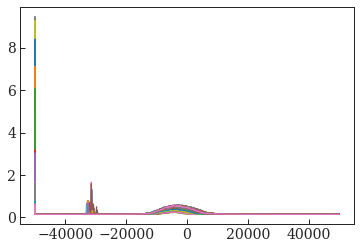

In [10]:
# Plot position vs profile
dfV.apply(lambda x: plt.plot( x['PR.BWS.85.V_ROT:PROF_POSITION_IN'],x['PR.BWS.85.V_ROT:PROF_DATA_IN']) ,axis=1);

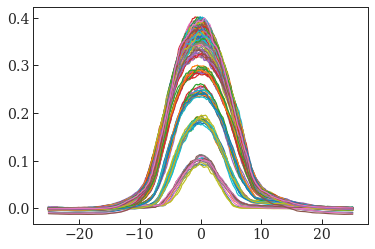

In [11]:
dfV.apply(lambda x: plt.plot( x['position V'],x['profile V']) , axis=1);

# Horizontal Timber

In [ ]:
dfH=read_data(year=2018,date=22,month=10,hour=15,minutes=4,span=5,user='CPS%MD5',WS='65.H')
dfH=profiles(dfH, WS='65.H')
dfH

In [ ]:
dfH=dfH.dropna(axis=0,how='all',subset =['profile H'])
dfH=dfH.dropna(axis=0,how='all',subset =['sig H'])
dfH

In [ ]:
# Plot position vs profile
dfH.apply(lambda x: plt.plot( x['PR.BWS.65.H_ROT:PROF_POSITION_IN'],x['PR.BWS.65.H_ROT:PROF_DATA_IN']) ,axis=1);

In [ ]:
dfH.apply(lambda x: plt.plot( x['position H'],x['profile H']) , axis=1);

## Merge and calculate emittances

In [ ]:
# Let's compare the dataframes and see if they have the correct timestamps
df_V = dfV
df_V

In [ ]:
df_V = df_V.drop(labels='PR.BWS.85.V_ROT:PROF_POSITION_IN',axis='columns')
df_V = df_V.drop(labels='PR.BWS.85.V_ROT:PROF_DATA_IN',axis='columns')
df_V = df_V.drop(labels='PR.BCT.LT:SAMPLES',axis='columns')
#df_V

In [ ]:
df_V['cycleStamp']=df_V['cycleStamp']/1e9
df_V['timeStamp']=df_V['cycleStamp'].apply(myToolbox.unixtime2datetimeVectorize)
df_V

In [ ]:
# If we use merge then cyclestamp will be treated as an integer comparison
matched = 0
tol_limit = 5000
tol=[]

# Iterate through cyclestamps in timber data
for i, r in df_mergetest.iterrows():        
    
    # See if we can find a match in df_mergetest
    for index, row in df_V.iterrows():
        tolerance = abs(float(r['cf_cycleStamp'] - row['cycleStamp']))   
        if tolerance <= tol_limit:
            a = pnd.Timedelta(r['cf_cycleStamp'] - row['cycleStamp'])
            tol.append(a)
            #print 'cyclestamp = ', row['cycleStamp'], ' cf_cycleStamp = ', r['cf_cycleStamp'], ' matched'
            matched = matched +1
            break
            
print 'total of ', matched, ' shots matched with tolerance = ', tol_limit, ', tol = '
print tol

In [ ]:
df_V

In [ ]:
df_mergetest

In [ ]:
# Merge tunes, intensities, with WS fits (vertical)
a = pnd.Timedelta('0 days 00:00:40')
df_new_V = pnd.merge_asof(df_V, df_mergetest, left_on='timeStamp', right_on = 'timeStamp', tolerance=a, allow_exact_matches=True)
df_new_V

In [ ]:
# Calculate emittances in Vertical
df_emit_V = emittance_df(df_new_V, WS='85.V')

In [ ]:
df_emit_V = df_emit_V.dropna(axis=0,how='all',subset =['Qy'])
df_emit_V = df_emit_V.dropna(axis=0,how='all',subset =['sig V'])
df_emit_V = df_emit_V.drop(labels='emittance H',axis='columns')
df_emit_V

In [ ]:
# Let's compare the dataframes and see if they have the correct timestamps
df_H = dfH
df_H

In [ ]:
df_H = df_H.drop(labels='PR.BWS.65.H_ROT:PROF_POSITION_IN',axis='columns')
df_H = df_H.drop(labels='PR.BWS.65.H_ROT:PROF_DATA_IN',axis='columns')
df_H = df_H.drop(labels='PR.BCT.LT:SAMPLES',axis='columns')

In [ ]:
df_H['cycleStamp']=df_H['cycleStamp']/1e9
df_H['timeStamp']=df_H['cycleStamp'].apply(myToolbox.unixtime2datetimeVectorize)
df_H

In [ ]:
# Merge tunes, intensities, with WS fits (vertical)
df_new_H = pnd.merge_asof(df_mergetest, df_H, left_on='timeStamp', right_on = 'timeStamp', direction='nearest')
df_new_H

In [ ]:
# Calculate emittances in Vertical
df_emit_H = emittance_df(df_new_H, WS='65.H')
df_emit_H = df_H.dropna(axis=0,how='all',subset =['Qx'])
df_emit_H = df_H.dropna(axis=0,how='all',subset =['sig H'])
df_emit_H = df_emit_H.drop(labels='emittance V',axis='columns')
df_emit_H

In [ ]:
# Remove unwanted columns from horizontal emittance df
df_emit_H = df_emit_H.drop(labels='Qx',axis='columns')
df_emit_H = df_emit_H.drop(labels='Qy',axis='columns')
df_emit_H = df_emit_H.drop(labels='intensity',axis='columns')
df_emit_H = df_emit_H.drop(labels='losses',axis='columns')
df_emit_H = df_emit_H.drop(labels='ratio',axis='columns')
df_emit_H = df_emit_H.drop(labels='profile H',axis='columns')
df_emit_H = df_emit_H.drop(labels='profile V',axis='columns')

In [ ]:
#df_V=pnd.merge(df,dfV,left_index=True, right_index=True, how='outer')
df_V=df_V.dropna(axis=0,how='all',subset =['matlabPLS_x'])
df_V=df_V.dropna(axis=0,how='all',subset =['PR_BQS72.SamplerAcquisition.value.estimatedTuneV'])
df_V=df_V.dropna(axis=0,how='all',subset =['PR_BQS72.SamplerAcquisition.value.estimatedTuneH'])
df_V

In [ ]:
df_V=emittance_df(df_V,WS='85.V')
#PR.BWS.85.V_ROT:PROF_DATA_IN
df_V = df_V.dropna(axis=0,how='all',subset =['Qy'])
df_V = df_V.dropna(axis=0,how='all',subset =['sig V'])

df_V

In [ ]:
df_H=pnd.merge(df,dfH,left_index=True, right_index=True, how='outer')

In [ ]:
df_H=df_H.dropna(axis=0,how='all',subset =['matlabPLS_y'])
df_H=emittance_df(df_H,WS='65.H', dp=5.5E-4)
df_H

In [ ]:
df_H=df_H.dropna(axis=0,how='all',subset =['Qx'])
df_H=df_H.dropna(axis=0,how='all',subset =['sig H'])
df_H=df_H.dropna(axis=1,how='all')
df_H

# Emittances

In [ ]:
df_V['second_moment V']=df_V.apply(lambda x: second_moment_2(x['position V'], x['profile V'], x['sig V'], n_sigmas=6.), axis=1);
df_H['second_moment H']=df_H.apply(lambda x: second_moment_2(x['position H'], x['profile H'], x['sig H'], n_sigmas=6.), axis=1);

In [ ]:
df_V.apply(lambda x: plt.scatter( x['Qy'], x['emittance V']) ,axis=1);
plt.xlabel('Qy (Fractional)')
plt.ylabel('Emittance y [mm mrad]')

In [ ]:
df_H.apply(lambda x: plt.scatter( x['Qy'], x['emittance H']) ,axis=1);
plt.xlabel('Qy (Fractional)')
plt.ylabel('Emittance x [mm mrad]')

In [ ]:
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==172)], df_V['emittance V'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==175)], df_V['emittance V'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==185)], df_V['emittance V'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qy (Fractional)')
plt.ylabel('Emittance y [mm mrad]')
plt.ylim(2,6)
plt.legend()
plt.title('Vertical Scan: Wire Scanner Acquisition Delay')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_WS_Delay_Emittance.png')

In [ ]:
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_H['Qy'][(df_H['PR.BWS.65.H_ROT:ACQ_DELAY']==172)], df_H['emittance H'][(df_H['PR.BWS.65.H_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(df_H['Qy'][(df_H['PR.BWS.65.H_ROT:ACQ_DELAY']==175)], df_H['emittance H'][(df_H['PR.BWS.65.H_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(df_H['Qy'][(df_H['PR.BWS.65.H_ROT:ACQ_DELAY']==185)], df_H['emittance H'][(df_H['PR.BWS.65.H_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qy (Fractional)')
plt.ylabel('Emittance x [mm mrad]')
plt.legend()
plt.title('Vertical Scan: Wire Scanner Acquisition Delay')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_WS_Delay_EmittanceH.png')

In [ ]:
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==172)], df_V['second_moment V'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==175)], df_V['second_moment V'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==185)], df_V['second_moment V'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qy (Fractional)')
plt.ylabel('second_moment V')
plt.legend()
plt.title('Vertical Scan: Wire Scanner Acquisition Delay')

In [ ]:
plt.plot(df_H['Qy'][(df_H['PR.BWS.65.H_ROT:ACQ_DELAY']==172)], df_H['second_moment H'][(df_H['PR.BWS.65.H_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(df_H['Qy'][(df_H['PR.BWS.65.H_ROT:ACQ_DELAY']==175)], df_H['second_moment H'][(df_H['PR.BWS.65.H_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(df_H['Qy'][(df_H['PR.BWS.65.H_ROT:ACQ_DELAY']==185)], df_H['second_moment H'][(df_H['PR.BWS.65.H_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qy (Fractional)')
plt.ylabel('second_moment H')
plt.legend()
plt.title('Vertical Scan: Wire Scanner Acquisition Delay')

In [ ]:
plt.plot([0.025, .11], [.305, .305], 'k-', lw=1.5, label='Qx = 0.305')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==172)], df_V['Qx'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==175)], df_V['Qx'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==185)], df_V['Qx'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qy (Fractional)')
plt.ylabel('Qx (Fractional)')
plt.legend()
#plt.ylim(0.29, 0.32)

# Merge Vertical and Intensity

In [ ]:
df_V

In [ ]:
df_intensity

In [ ]:
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_new['Qy'][(df_new['PR.BWS.85.V_ROT:ACQ_DELAY']==172)], df_new['losses'][(df_new['PR.BWS.85.V_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(df_new['Qy'][(df_new['PR.BWS.85.V_ROT:ACQ_DELAY']==175)], df_new['losses'][(df_new['PR.BWS.85.V_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(df_new['Qy'][(df_new['PR.BWS.85.V_ROT:ACQ_DELAY']==185)], df_new['losses'][(df_new['PR.BWS.85.V_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qy (Fractional)')
plt.ylabel('Losses [%]')
plt.legend()
plt.title('Vertical Scan: Losses')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_Losses_vs_WS_Acqusition.png')

In [ ]:
df_newH=pnd.merge(dfH, df_intensity, left_index=True, right_index=True, how='outer')
df_newH=df_newH.dropna(axis=0,how='all',subset =['Qx'])
df_newH=df_newH.dropna(axis=0,how='all',subset =['sig H'])
df_newH

In [ ]:
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_newH['Qx'][(df_newH['PR.BWS.65.H_ROT:ACQ_DELAY']==172)], df_newH['losses'][(df_newH['PR.BWS.65.H_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(df_newH['Qx'][(df_newH['PR.BWS.65.H_ROT:ACQ_DELAY']==175)], df_newH['losses'][(df_newH['PR.BWS.65.H_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(df_newH['Qx'][(df_newH['PR.BWS.65.H_ROT:ACQ_DELAY']==185)], df_newH['losses'][(df_newH['PR.BWS.65.H_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qx (Fractional)')
plt.ylabel('Losses [%]')
plt.legend()
plt.title('Vertical Scan: Losses')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_Losses_vs_WS_Acqusition_H.png')

# Tunespread calculation

In [ ]:
%run /eos/user/h/harafiqu/SWAN_projects/PS/Tunespread_Calculator.ipynb

In [ ]:
myTFSFiles=glob.glob('/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_Twiss/*.tfs')
myTomoEvalFiles=glob.glob('/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_2018_10_22/tomo/*_eval.dat')
#myTFSFiles
#myTomoEvalFiles

In [ ]:
# This function takes a list of absolute paths to each file (use for example glob.glob('path_to_files/*.tfs'))
def create_dictionary_of_tfs_table_names(myTFSFiles):
    # We assume that we only vary tunes in one plane (vertical)
    TFSfiles = {}
    for item in myTFSFiles:
        absolute_filename = item                          # filepath
        filename = item.split('/')[-1]                    # filename
        integer = filename.split('p')[1].split('_')[1]    # integer Qy
        fractional = filename.split('p')[2].split('.')[0] # fractional Qy
        qy_str = (integer + '.' + fractional)             # concatenate strings
        qy_float = float(qy_str)                          # convert to float

        TFSfiles.update({qy_str : absolute_filename})
    return TFSfiles   

In [ ]:
TFSfiles = create_dictionary_of_tfs_table_names(myTFSFiles)
#TFSfiles

In [ ]:
# Let's look at the interval between tomo file times, and data file times
tomo_interval=[]
data_interval=[]

# find first tomo timestamp
first_tomo_timestamp = float(extract_long_eval(myTomoEvalFiles[0])['time'])

for i in range(len(myTomoEvalFiles)):
    if i == 0:                     # First pass will have no interval
        pass
    else:
        interval = float(extract_long_eval(myTomoEvalFiles[i])['time']) - float(extract_long_eval(myTomoEvalFiles[i-1])['time'])
        tomo_interval.append(interval)

print 'Tomo files: time interval between files\n Mean:',np.mean(tomo_interval),' Min:',np.min(tomo_interval),' Max:', np.max(tomo_interval)

# should technically set the tolerance when comparing data and tomo times to min/2

# Iterate over each row in the dataframe
for i in range(len(df_new.index)):    
    if i==0:
        pass
    elif i==len(df_new.index):
        pass
    else:
        interval = df_new.iloc[i]['cycleStamp']/1E9 - df_new.iloc[i-1]['cycleStamp']/1E9
        data_interval.append(interval)

print '\nData files: time interval between files\n Mean:',np.mean(data_interval),' Min:',np.min(data_interval),' Max:', np.max(data_interval)

In [ ]:
from math import log10, floor
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

# find first tomo timestamp
first_tomo_timestamp = float(extract_long_eval(myTomoEvalFiles[0])['time'])
print 'first recorded tomo at t = ', first_tomo_timestamp

# find first data timestamp
row = next(df_new.iterrows())[1]
first_data_timestamp = row['cycleStamp']/1E9
print 'first recorded data at t = ', first_data_timestamp

# Iterate over each row in the dataframe
for index, row in df_new.iterrows():
    
    integer_tune = 6
    fractional_tune = round_sig(row['Qy'],1)
    tune = integer_tune + fractional_tune
    
    # we want to use this twiss file:
    absolute_tfs_filename = TFSfiles[str(tune)]
    
    # Iterate through tomo files to find corresponding data
    for item in myTomoEvalFiles:
        tomoData = extract_long_eval(item)
        
        # use cyclestamp to find correct tomo file
        if abs(tomoData['time'] - (row['cycleStamp']/1E9)) < 20:
            print 'tomo file matched at tomo = ', tomoData['time'], ', data time = ', (row['cycleStamp']/1E9), ', diff = ', (tomoData['time'] - (row['cycleStamp']/1E9))
            
            # We are at the correct row in the dataframe, and have identified the correct tomo file
            # Let's do some tunespread calculation!
            
            # Read TFS table
            tfsData = read_tfs_table_return_data(absolute_tfs_filename)
            
            # Create dictionary for tunespread tool:
            #make_tst_inputs(intensity, deltap, emit_geo_x, emit_geo_y, std_x_div_by_Dx, lorentz_beta=0.91444281513833, lorentz_gamma=2.4708737618826, mass=m_p):
            inputData = make_tst_inputs(row['intensity'], tomoData['deltap'], row[''] )
            
            #tomoData
            
            
        else: 
            pass
            #print 'tomo not found for this shot', tomoData['time'], ', data time = ', (row['cycleStamp']/1E9)
            
    print 'Ended single dataframe iteration'

In [ ]:
# Iterate through tomo files
for item in myTomoFiles:
    print item
    tomoData = extract_long_eval(item)
    print tomoData['time']
    # use cyclestamp to find correct tomo file
    if tomoData['time'] == row['cycleStamp']:
        print 'tomo file matched'